# `diffusive_size_factor_AI`

PoreSpy's `diffusive_size_factor_AI` includes the steps for predicting the diffusive size factors of the conduit images decribed [here](https://doi.org/10.1016/j.cageo.2022.105086). Note that the diffusive conductance of the conduits can be then calculated by multiplying the size factor by diffusivity of the phase. The function takes in the images of segmented porous medium and returns an array of diffusive size factors for all conduits in the image. Therefore, the framework can be applied to both one conduit image as well as a segmented image of porous medium.

<img src="https://user-images.githubusercontent.com/43128873/116145783-bd458380-a6ab-11eb-8103-fb9a93f0599c.png" alt="PS_dl" width="700"/>

## Trained model and supplementary materials
To use the `diffusive_size_factor_AI`, the trained model, and training data distribution are required. The AI model files and additional files used in this example are available [here](https://dl.dropboxusercontent.com/s/jrq82twl0vwedy4/AI_example_data.rar?dl=0). The folder contains following files:

- Trained model weights: This file includes only weights of the deep learning layers. To use this file, the Resnet50 model structure must be built first.
- Trained data distribution: This file will be used in denormalizing predicted values based on normalized transform applied on training data. The denormalizing step is included in `diffusive_size_factor_AI` method.
- Finite difference diffusive conductance: This file is used in this example to compare the prediction results with finite difference method for segmented regions
- Pair of regions: This file is used in this example to compare the prediction results with finite difference method for a pair of regions

Let's download the `tensorflow` files required to run this notebook:

In [1]:
try:
    import tensorflow as tf
except ImportError:
    !pip install tensorflow

try:
    import sklearn
except ImportError:
    !pip install scikit-learn

import os

if not os.path.exists("sf-model-lib"):
    !git clone https://github.com/PMEAL/sf-model-lib

2023-03-23 14:30:32.511524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Also, since the model weights have been stored in chunks, they need to be recombined first:

In [2]:
import importlib
h5tools = importlib.import_module("sf-model-lib.h5tools")
DIR_WEIGHTS = "sf-model-lib/diffusion"
fname_in = [f"{DIR_WEIGHTS}/model_weights_part{j}.h5" for j in [0, 1]]
h5tools.combine(fname_in, fname_out=f"{DIR_WEIGHTS}/model_weights.h5")

Note that to use `diffusive_size_factor_AI`, [Scikit-learn](https://scikit-learn.org/stable/index.html?msclkid=9e175644bb2511ecb89dded5ce21b89f) and [Tensorflow](https://www.tensorflow.org/?msclkid=a5a214bdbb2511ecadd52383bd2650c1) must be installed. Import necessary packages and the AI model:

In [3]:
import inspect
import os
import warnings

import h5py
import numpy as np
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

ps.visualization.set_mpl_style()
warnings.filterwarnings("ignore")
inspect.signature(ps.networks.diffusive_size_factor_AI)

<Signature (regions, throat_conns, model, g_train, voxel_size=1)>

## `model` , `g_train`

Import AI model and training data from the downloaded folder:

In [4]:
path = "./sf-model-lib/diffusion"
path_train = os.path.join(path, 'g_train_original.hdf5')
path_weights = os.path.join(path, 'model_weights.h5')
g_train = h5py.File(path_train, 'r')['g_train'][()]
model = ps.networks.create_model()
model.load_weights(path_weights)

2023-03-23 14:30:39.889200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[14:30:41] WARNING  `lr` is deprecated, please use `learning_rate` instead, or use the legacy      ]8;id=450291;file:///home/anaconda/mambaforge/envs/tensorflow_env/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py\optimizer.py]8;;\:]8;id=366705;file:///home/anaconda/mambaforge/envs/tensorflow_env/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py#106\106]8;;\
                    optimizer, e.g.,tf.keras.optimizers.legacy.Adam.                                               

## `regions`

We can create a 3D image using PoreSpy's `poly_disperese_spheres` generator and segment the image using `snow_partitioning` method. Note that `find_conns` method returns the connections in the segmented region. The order of values in conns is similar to the network extraction conns. Therefore, the region with label=1 in the segmented image is mapped to indice 0 in conns.

0it [00:00, ?it/s]

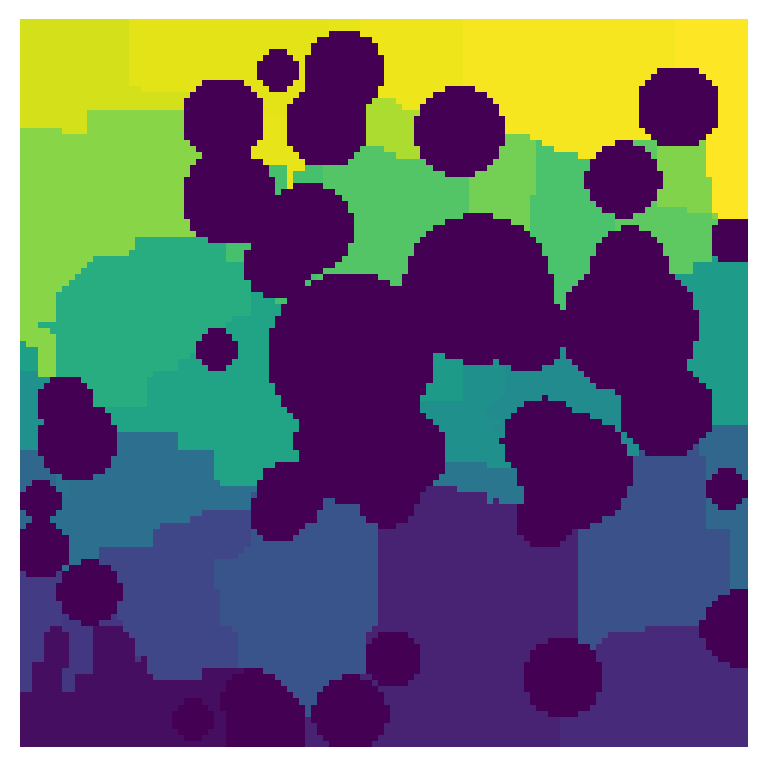

In [5]:
np.random.seed(17)
shape = [120, 120, 120]
dist = sp.stats.norm(loc=7, scale=5)
im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.7,
                                        dist=dist,
                                        r_min=7)
results = ps.filters.snow_partitioning(im=im.astype(bool))
regions = results['regions']
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(regions[:, :, 20], origin='lower', interpolation='none')
ax.axis(False);

## `throat_conns`

PoreSpy's `diffusive_size_factor_AI` method takes in the segmented image, model, training ground truth values, and the conncetions of regions in the segmented image (throat conns). In this example we have created an image with voxel_size=1. For a different voxel size, the voxel_size argument needs to be passed to the method.

In [6]:
conns = ps.networks.find_conns(regions)
size_factors = ps.networks.diffusive_size_factor_AI(regions,
                                                    model=model,
                                                    g_train=g_train,
                                                    throat_conns=conns)

Finding neighbouring regions:   0%|          | 0/199 [00:00<?, ?it/s]

Preparing images tensor:   0%|          | 0/744 [00:00<?, ?it/s]

47/47 [==============================] - 43s 861ms/step


## Compare with finite difference

Assuming a diffusivity of 1, the diffusive conductance of the conduits will be equal to their diffusive size factors. Now let's compare the AI-based diffusive conductances with the conductance values calculated by finite difference method. The finite difference method results are found using the steps explained [here](https://doi.org/10.1016/j.cageo.2022.105086).

Note: The finite difference-based diffusive size factors were calculated using PoreSpy's size factor method `diffusive_size_factor_DNS`.  However, due to the long runtime of the DNS function the results were saved in the example data folder and used in this example. The Following code was used to estimate the finite difference-based values using PoreSpy: 
```python
g_FD = ps.networks.diffusive_size_factor_DNS(regions, conns)
```

The R^2 prediction accuracy is 0.977


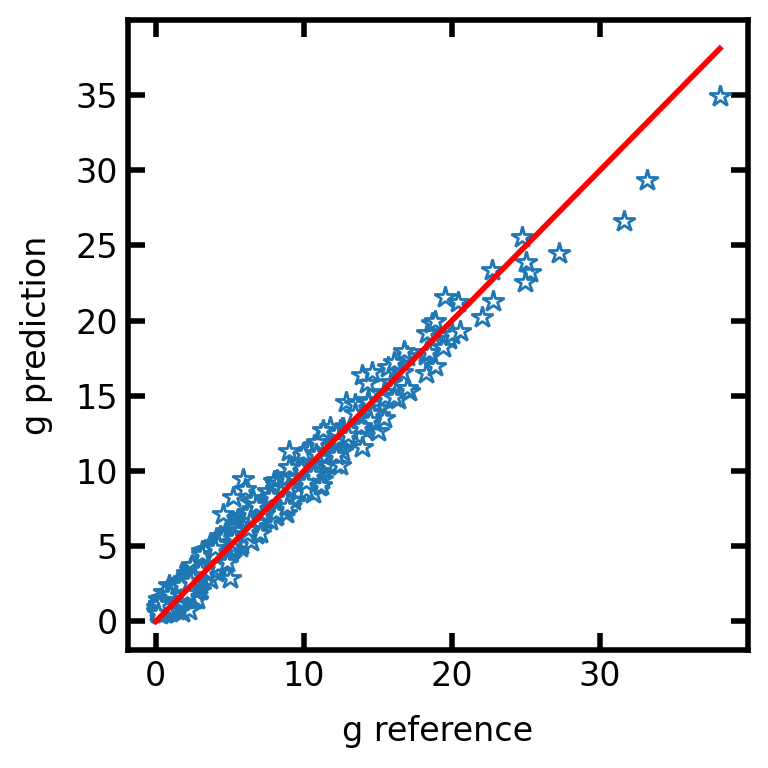

In [7]:
fname = os.path.join(path, 'g_finite_difference120-phi7.hdf5')
g_FD = h5py.File(fname, 'r')['g_finite_difference'][()]
g_AI = size_factors
max_val = np.max([g_FD, g_AI])
plt.figure(figsize=[4, 4])
plt.plot(g_FD, g_AI, '*', [0, max_val], [0, max_val], 'r')
plt.xlabel('g reference')
plt.ylabel('g prediction')
r2 = r2_score(g_FD, g_AI)
print(f"The R^2 prediction accuracy is {r2:.3}")

Note on runtime: A larger part of `AI_size_factors` runtime is related to extracting the pairs of conduits, which is the common step required for both AI and finite difference method. Once the data is prepared, AI Prediction on the tensor takes a smaller amount of time in contrast to finite difference method, as it was shown [here]((https://doi.org/10.1016/j.cageo.2022.105086)). 

## Apply on one conduit

PoreSpy's `diffusive_size_factor_AI` method can take in an image of a pair of regions. Let's predict the diffusice size factor for a pair of image using both AI and DNS methods:

In [8]:
fname = os.path.join(path, 'pair.hdf5')
pair_in = h5py.File(fname, 'r')
im_pair = pair_in['pair'][()]
conns = ps.networks.find_conns(im_pair)
sf_FD = ps.networks.diffusive_size_factor_DNS(im_pair, throat_conns=conns)
sf_AI = ps.networks.diffusive_size_factor_AI(im_pair,
                                             model=model,
                                             g_train=g_train,
                                             throat_conns=conns)
print(f"Diffusive size factor from FD: {sf_FD[0]:.2f}, and AI: {sf_AI[0]:.2f}")

Finding neighbouring regions:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing images and DNS calculations:   0%|          | 0/1 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Preparing images tensor:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step
Diffusive size factor from FD: 8.39, and AI: 8.47
